I would like to create an automated process that alows me to copy and paste raw data into a function to provide me with all the data required to create all required origin graphs.

AI was used in partial creation of this code.

In [1]:
import csv
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import os
import glob
import cmcrameri.cm as cmc
from decimal import Decimal

from pygments.lexer import default

In [2]:
h = 6.62606957 * 10 **(-34)
c0 = 299792458
charge = 1.602176565 * 10 ** (-19)
thickness = 1 * 10 **(-5)

In [3]:
#make a bunch of useful functions
def zero_remover(data): #Only for lists
    zero_removed_data = []
    for i in range(0,len(data)):
        if data[i] > 0:
            zero_removed_data.append(data[i])
        else:
            zero_removed_data.append(0)
    zero_removed_data = np.array(zero_removed_data)
    return zero_removed_data

def csv_to_numpy(csv_file):
    all_data = genfromtxt(csv_file,delimiter=",",dtype=float, missing_values=["NaN", "#DIV/0!"], filling_values=0)
    all_data_removed_headers = all_data[2:,:]
    cleaned_data = np.where(all_data_removed_headers > 0, all_data_removed_headers, 0)
    return cleaned_data

def seperated_data(clean_data):
    wavelength = np.array(clean_data[:,0])
    transmission0 = np.array(clean_data[:,1])
    transmission100 = np.array(clean_data[:,2])
    BA2PbI4 = np.array(clean_data[:,3])
    SC_BA2MAPb2I7 = np.array(clean_data[:,4])
    PC_BA2MAPb2I7 = np.array(clean_data[:,5])

    energy_J = h * c0 / (wavelength * (10 **(-9)))
    energy_eV = energy_J * charge
    incident = transmission100 - transmission0
    BA2PbI4_background = BA2PbI4 - transmission0
    SC_BA2MAPb2I7_background = SC_BA2MAPb2I7 - transmission0
    PC_BA2MAPb2I7_background = PC_BA2MAPb2I7 - transmission0
    return energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background

def all_calcs(incident, material):
    tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
    absorbance = np.log10(incident / material)
    coefficient_literature = (np.log(10)/thickness) * absorbance
    return tranmission_material, absorbance, coefficient_literature

def transmissionPlot(wavelength, incident, Material_background, colour_index, key, key_index):
    tranmission_material, absorbance, coefficient_literature = all_calcs(incident, Material_background)

    index_add_value = key_index
    indexed_transmission_material = index_add_value + tranmission_material
    cmap = plt.cm.viridis
    colour = cmap(colour_index)
    plt.plot(wavelength, indexed_transmission_material, label= f"{key}h", color=colour, linewidth=2)
    return

def absorbancePlot(wavelength, incident, Material_background, colour_index, key, key_index):
    tranmission_material, absorbance, coefficient_literature = all_calcs(incident, Material_background)

    index_add_value = key_index
    indexed_transmission_material = index_add_value + absorbance
    cmap = plt.cm.viridis#cmc.batlow.resampled(25)
    colour = cmap(colour_index)
    plt.plot(wavelength, indexed_transmission_material, label= f"{key}h", color=colour, linewidth=2)
    return

def AbsCoPlot(wavelength, incident, Material_background, colour_index, key, key_index):
    tranmission_material, absorbance, coefficient_literature = all_calcs(incident, Material_background)

    index_add_value = key_index
    indexed_transmission_material = index_add_value + coefficient_literature
    cmap = plt.cm.viridis#cmc.batlow.resampled(25)
    colour = cmap(colour_index)
    plt.plot(wavelength, indexed_transmission_material, label= f"{key}h", color=colour, linewidth=2)
    return

def format_sig_fig(x, sig_fig):
    """
    Format a number x to sig_fig significant figures,
    preserving trailing zeros as decimal places when needed.
    """
    if x == 0:
        return f"{0:.{sig_fig}f}"  # just return 0.00... for consistency
    # Determine how many digits before decimal
    import math
    digits_before_decimal = int(math.floor(math.log10(abs(x)))) + 1
    decimals_needed = max(sig_fig - digits_before_decimal, 0)
    return f"{x:.{decimals_needed}f}"


In [14]:
#Load in the data
directory = r"A:\Y4 Project code\Data\Raw data"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))

data_dict = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    #print(key)
    key = key.replace("Easy access data - ", "", 1) #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    #print(key)
    short_key = key.split(" - ")[0].strip()
    short_key = short_key.split(" -")[0].strip()
    short_key = short_key.split("-")[0].strip() # remove everything after the "-" in the item called "short_key"

    short_key = short_key.replace("m", "",1)
    short_key = short_key.replace(" heat", "",1)

    hours = int(short_key.split("h")[0].strip())
    #print(hours, "hours")
    minutes = int(short_key.split("h")[1].strip()) if len(short_key) > 1 and short_key.split("h")[1].strip() else 0
    #print(minutes, "minutes")
    if minutes > 30:
        hours = hours + 1

    #print(short_key)
    #print(key)
    data_dict[str(hours)] = csv_to_numpy(file)
print(data_dict.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
for key in data_dict.keys():
    key_list.append(int(key))
    correct_key_order = np.argsort(key_list)
print(correct_key_order)


correct_keys = []

for key in correct_key_order:
    correct_keys.append(key_list[key])


new_dict = {}

for key in correct_keys:
    new_dict[str(key)] = data_dict[str(key)]
data_dict = new_dict
print(data_dict.keys()) #viola!

dict_keys(['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'])
[ 0  6  8 10 11 12 13 14  1  2  3  4  5  7  9]
dict_keys(['0', '1', '21', '26', '44', '50', '67', '73', '139', '162', '167', '185', '192', '209', '215'])


In [36]:
#functions to make the plots look a lot neater
def text_and_plot_stuff(figsize=(10,20), line_width=4, font_size=28, i=0):
    plt.rcParams.update({
        "font.size": font_size,
        "axes.titlesize": font_size+4,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size-4,
        "ytick.labelsize": font_size-4,
        "legend.fontsize": font_size-4
    })
    if i == 3 or i == 5:
        fig, ax = plt.subplots(figsize=figsize)
    elif i == 4:
        fig, ax = plt.subplots(figsize=(10,30))

    ax.axes.yaxis.set_ticklabels([])
    ax.tick_params(axis='both', width=line_width, length=20)
    ax.tick_params(axis='both', which='minor', length=10, width=line_width)

    for spine in ["bottom", "left", "top", "right"]:
        ax.spines[spine].set_linewidth(line_width)

    plt.grid(which='major', axis="y", linewidth=line_width/2)
    #plt.grid(which='minor', axis="y", linewidth=line_width/4)
    #plt.grid(which='major', axis="x", linewidth=line_width)
    #plt.grid(which='minor', axis="x", linewidth=line_width/4)
    return fig, ax

def set_y_ticks(ax, y_jumps):
    # cumulative boundaries: 0, y1, y1+y2, y1+y2+y3, ...
    major_positions = np.concatenate(([0], np.cumsum(y_jumps)))
    levels = len(y_jumps)

    # major ticks get the usual "0"
    ax.set_yticks(major_positions, ["0"] * (levels + 1))

    # fractions for minor ticks inside each block
    fractions = [5/24, 5/12, 15/24, 10/12]

    minor_positions = []
    minor_labels = []

    for idx, jump in enumerate(y_jumps):
        start = major_positions[idx]
        for f in fractions:
            minor_positions.append(start + f * jump)

            if f == 10/12:
                minor_labels.append(100)
            else:
                minor_labels.append(format(f * jump, ".2g"))

        minor_labels = [str(i) for i in minor_labels]

    ax.set_yticks(minor_positions, minor_labels, minor=True)

def add_scale_bars(ax, x_pos, y_jumps, color="red", line_width=4, x_displace=10, unit="", sig_fig =2):
    cum = np.concatenate(([0], np.cumsum(y_jumps)))
    levels = len(y_jumps)

    for idx, jump in enumerate(y_jumps):
        y_center = cum[idx] + jump / 2
        ax.errorbar(
            x=x_pos,
            y=y_center,
            yerr=jump / 2,
            capsize=10,
            linewidth=line_width / 2,
            markeredgewidth=2,
            color=color,
            label="_nolegend_",
        )

        formatted_jump = format_sig_fig(jump, sig_fig)

        ax.text(x_pos + x_displace, y_center, f"{formatted_jump} {unit}", va='center', label="_nolegend_")

def legend_setup():
    handles, labels = plt.gca().get_legend_handles_labels()
    neatened_labels = np.char.rstrip(labels, 'h').astype(float)
    order = np.argsort(neatened_labels)
    return handles, labels, order

[120.0, 120.0, 120.0, 120.0]


C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

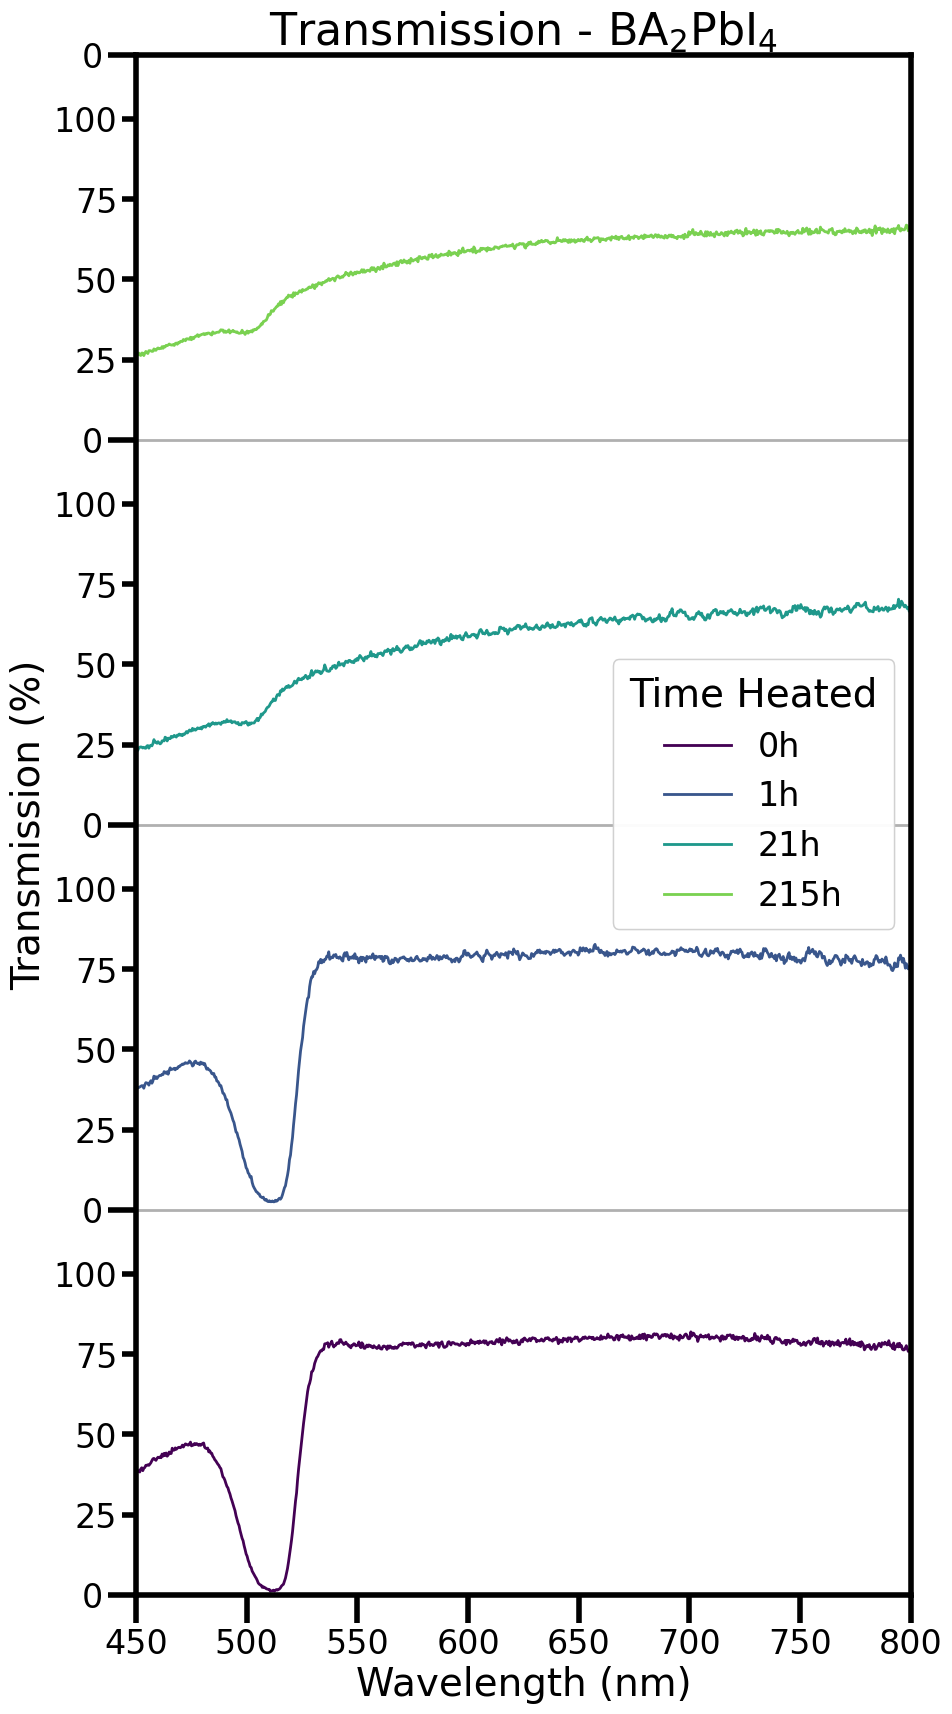

[96.0, 108.0, 84.0, 72.0, 45.6, 48.0]


C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

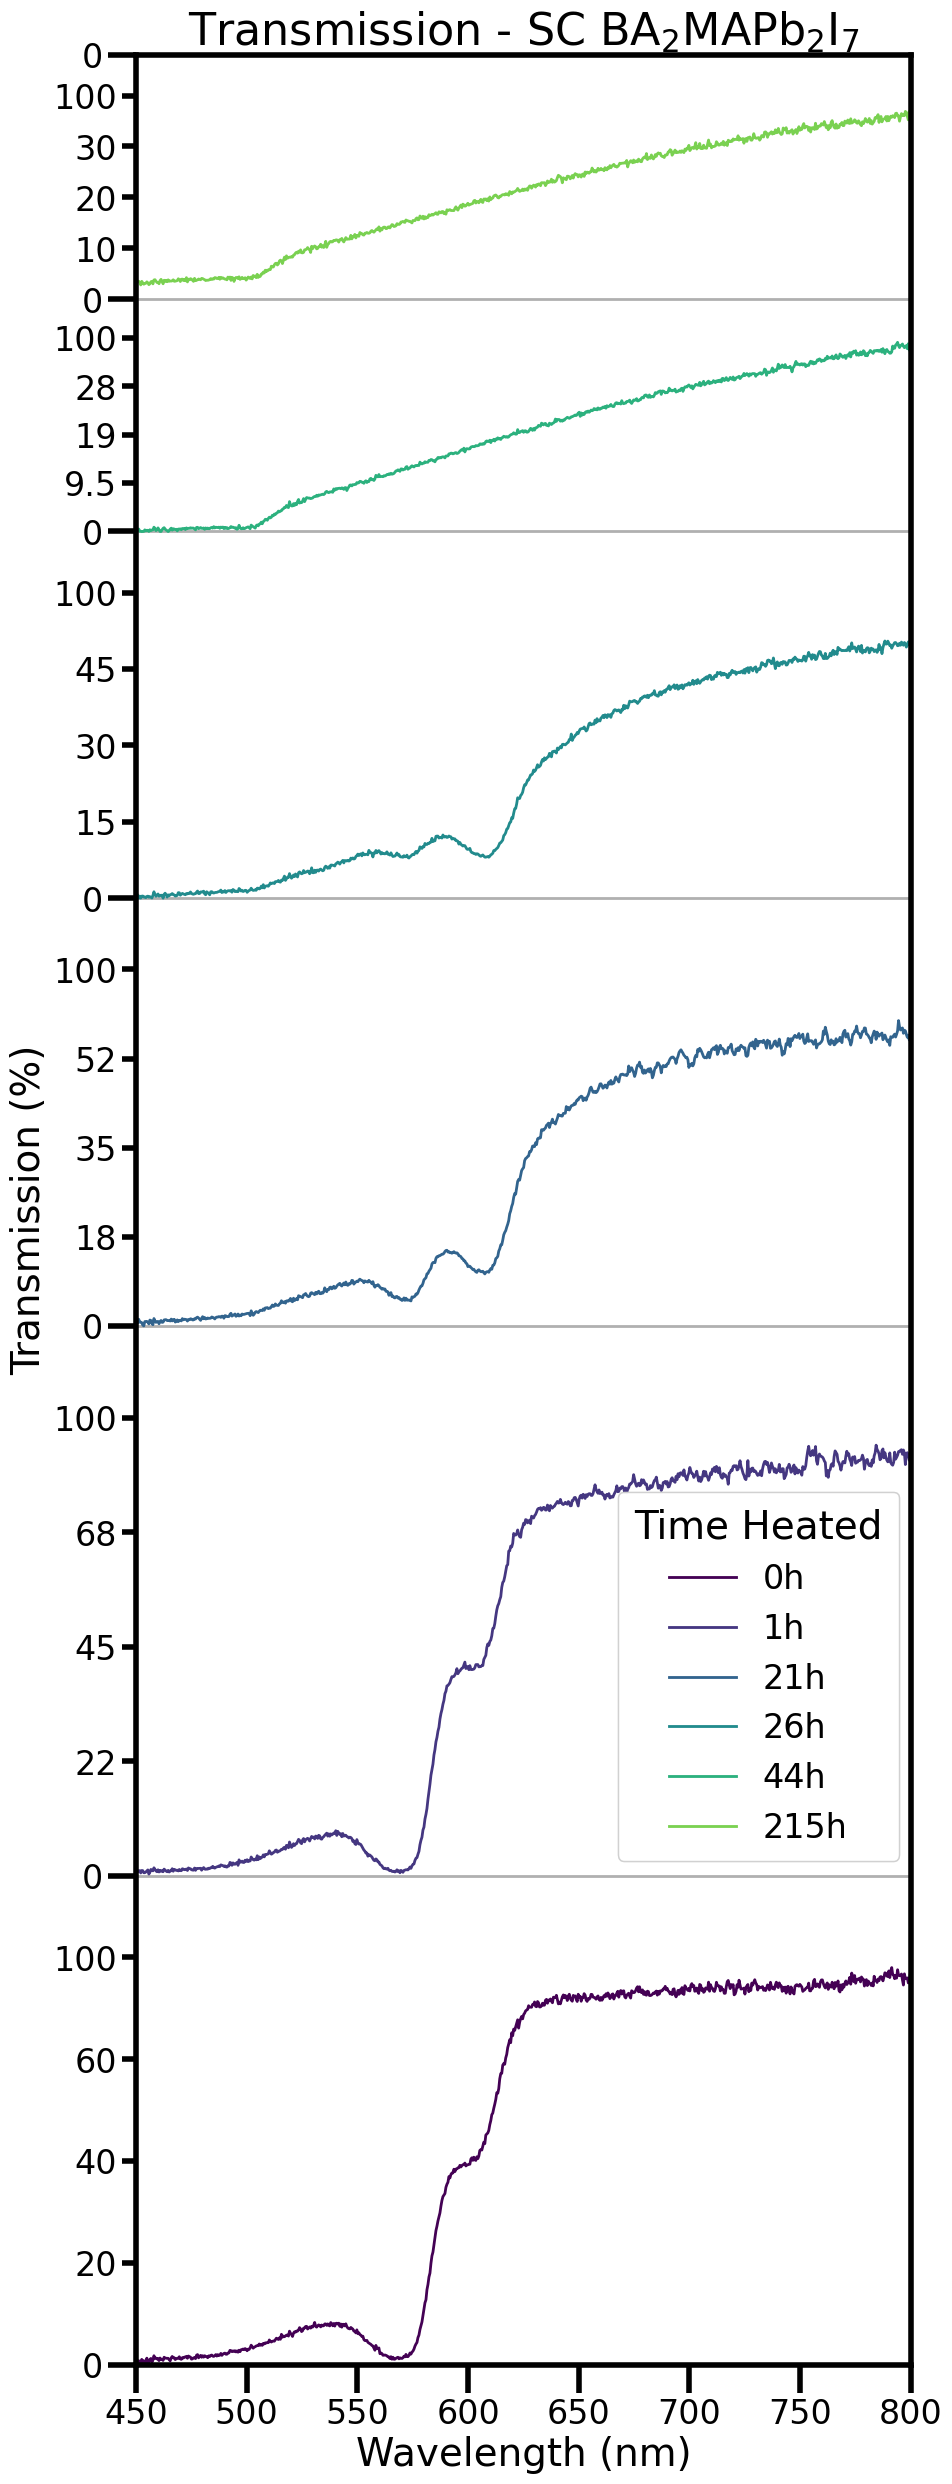

[90.0, 90.0, 72.0, 72.0]


C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

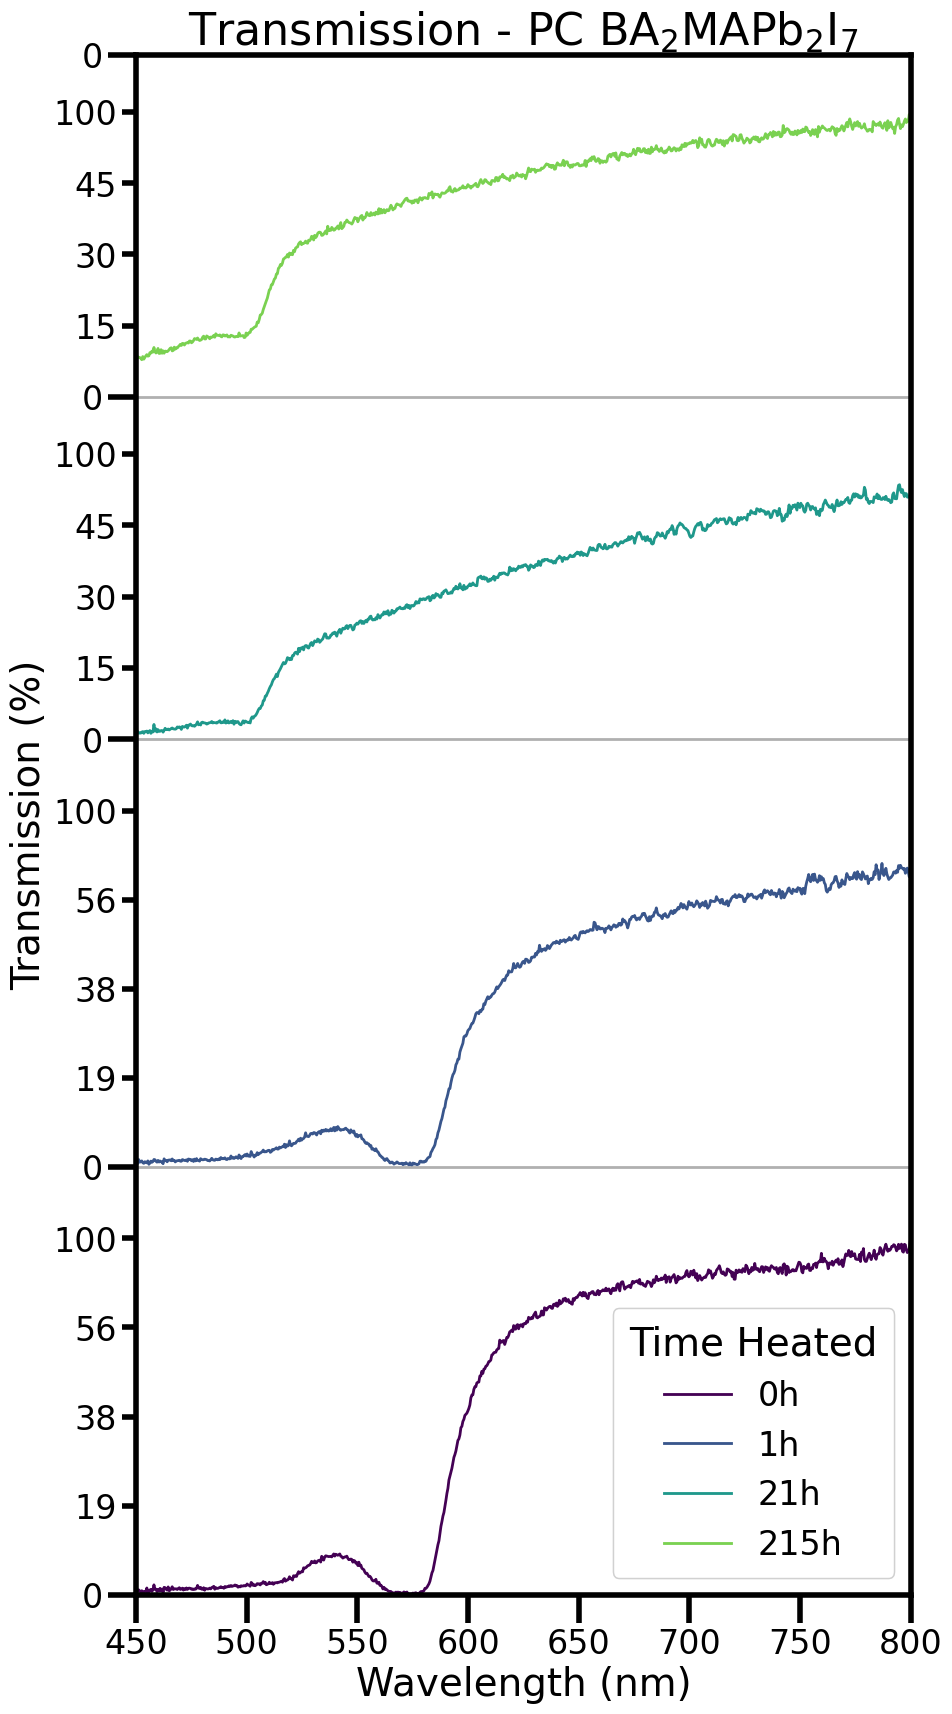

In [46]:
#for a graph of all transmissions for all times for a particular material.
line_width = 4

for i in [3, 4, 5]:
    # define y_jump per material
    if i == 3:
        #y_jump = [90, 90, 75, 75]
        y_jump= [100, 100, 100, 100]
    elif i == 4:
        y_jump = [80, 90, 70, 60, 38, 40]
    elif i == 5:
        y_jump = [75, 75, 60, 60]

    y_jump = [(120/100) * i for i in y_jump]
    print(y_jump)

    fig, ax = text_and_plot_stuff(figsize=(10,20), line_width=4, font_size=28, i=i)

    # set major and minor y-ticks using y_jump
    if i == 3 or i == 5:
        set_y_ticks(ax, y_jump)
    elif i == 4:
        set_y_ticks(ax, y_jump)

    ax.set_xticks([350, 450, 550, 650, 750], minor=True)

    # scale bar using y_jump
    #if i == 3:
        #add_scale_bars(ax, x_pos=725, y_jumps=y_jump, unit="%", x_displace=5, sig_fig =2)
    #elif i == 4:
        #add_scale_bars(ax, x_pos=475, y_jumps=y_jump, unit="%", x_displace=5, sig_fig =2)
    #elif i == 5:
        #add_scale_bars(ax, x_pos=465, y_jumps=y_jump, unit="%", x_displace=5, sig_fig =2)

    #if we want to disclude any graphs:
    times_indexs_not_to_plot = [3, 4, 5, 6, 7, 8, 9, 10, 11,12, 13]
    if i == 4:
        del times_indexs_not_to_plot[:2]

    valid_keys = [key for key_index, key in enumerate(data_dict) if key_index not in times_indexs_not_to_plot]

    y_value_to_start = 0
    nth_plot = 0

    for key_index, key in enumerate(data_dict):
        if key_index in times_indexs_not_to_plot:
            continue
        nth_plot += 1
        energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background = seperated_data(data_dict[key])
        colour_index = (nth_plot-1) / (len(valid_keys)-1) * 0.8
        if i == 3:
            transmissionPlot(wavelength, incident, BA2PbI4_background, colour_index, key, y_value_to_start)
        elif i == 4:
            transmissionPlot(wavelength, incident, SC_BA2MAPb2I7_background, colour_index, key, y_value_to_start)
        elif i == 5:
            transmissionPlot(wavelength, incident, PC_BA2MAPb2I7_background, colour_index, key, y_value_to_start)
        y_value_to_start += y_jump[nth_plot - 1]

    plt.ylim(0, y_value_to_start)
    plt.xlim(450, 800)

    # material name
    name = {3:r"BA$_{2}$PbI$_{4}$", 4:r"SC BA$_{2}$MAPb$_{2}$I$_{7}$", 5:r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"}[i]
    plt.title(f"Transmission - {name}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission (%)")

    # legend
    handles, labels, order = legend_setup()
    if i == 3:
        Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="center right", title="Time Heated", borderpad=0.5, bbox_to_anchor=(1, 0.52))
    elif i == 4:
        Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="best", title="Time Heated", borderpad=0.5, bbox_to_anchor=(0.6, 0.298))
    elif i == 5:
        Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="best", title="Time Heated", borderpad=0.5)
    plt.gca().add_artist(Plot_legend)#bbox_to_anchor=(1, 0.298)

    # save
    name = {3:"BA2PbI4", 4:"SC BA2MAPb2I7", 5:"PC BA2MAPb2I7"}[i]
    vector_image = os.path.join(r"A:\Y4 Project code\Graphs", f"{name} Transmission.svg")
    png_image = os.path.join(r"A:\Y4 Project code\Graphs", f"{name} Transmission.png")
    plt.savefig(vector_image, bbox_inches='tight')
    plt.savefig(png_image, dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

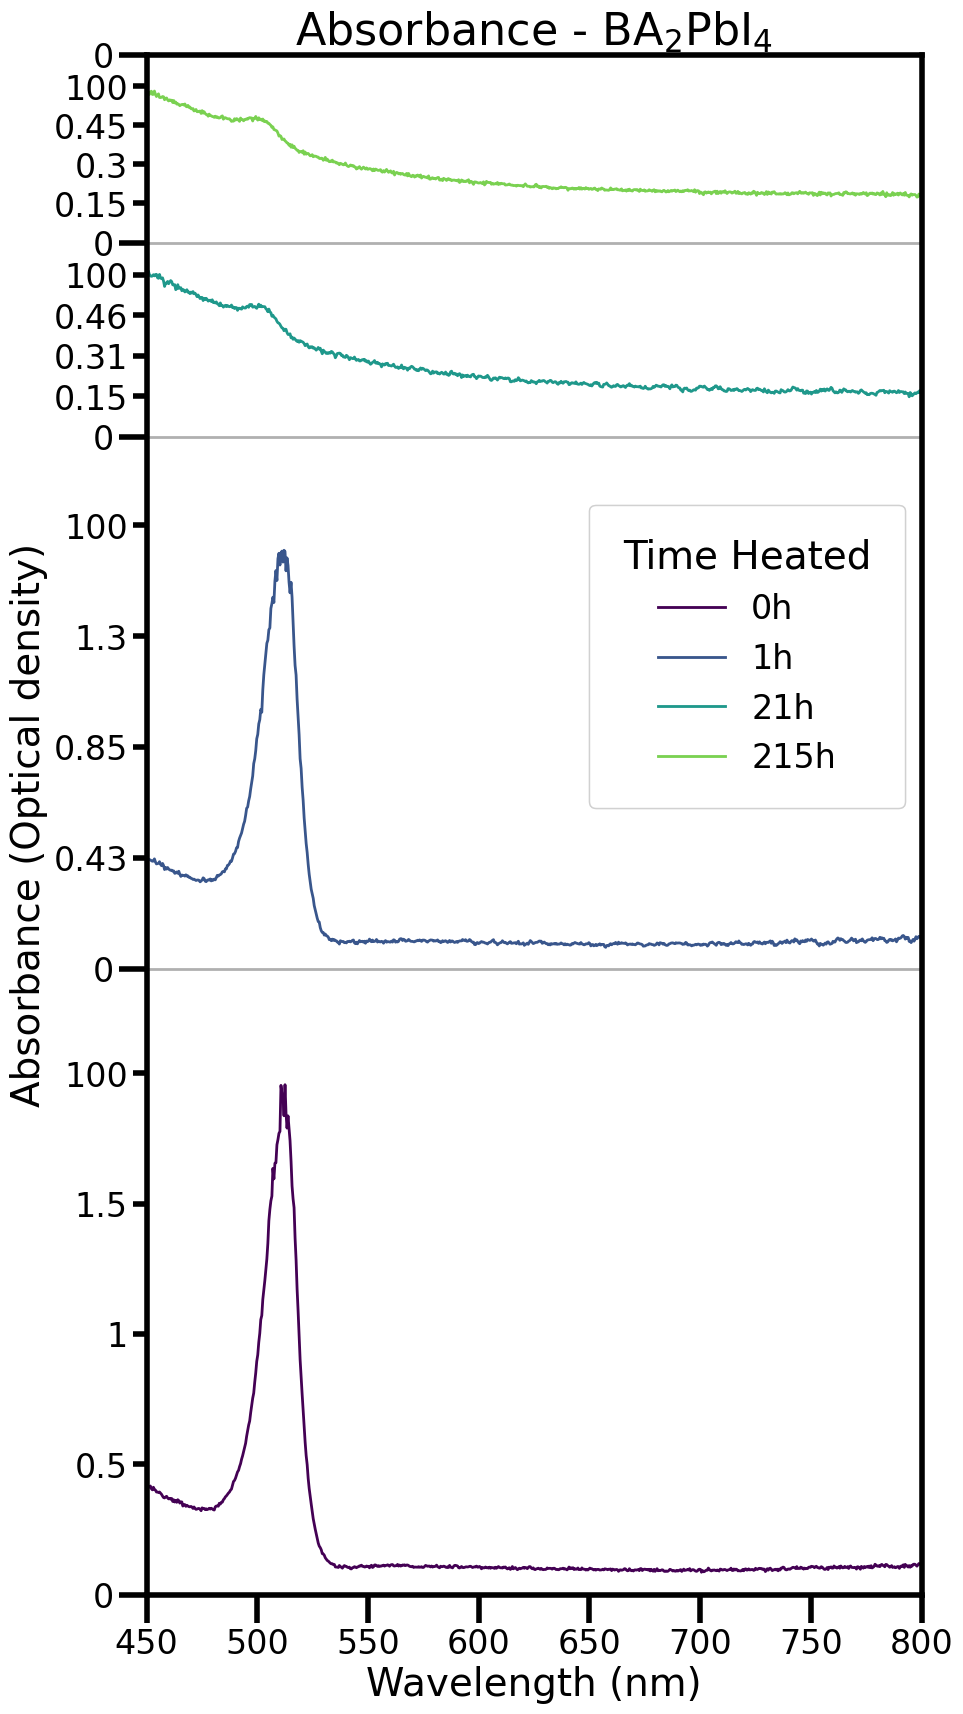

C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

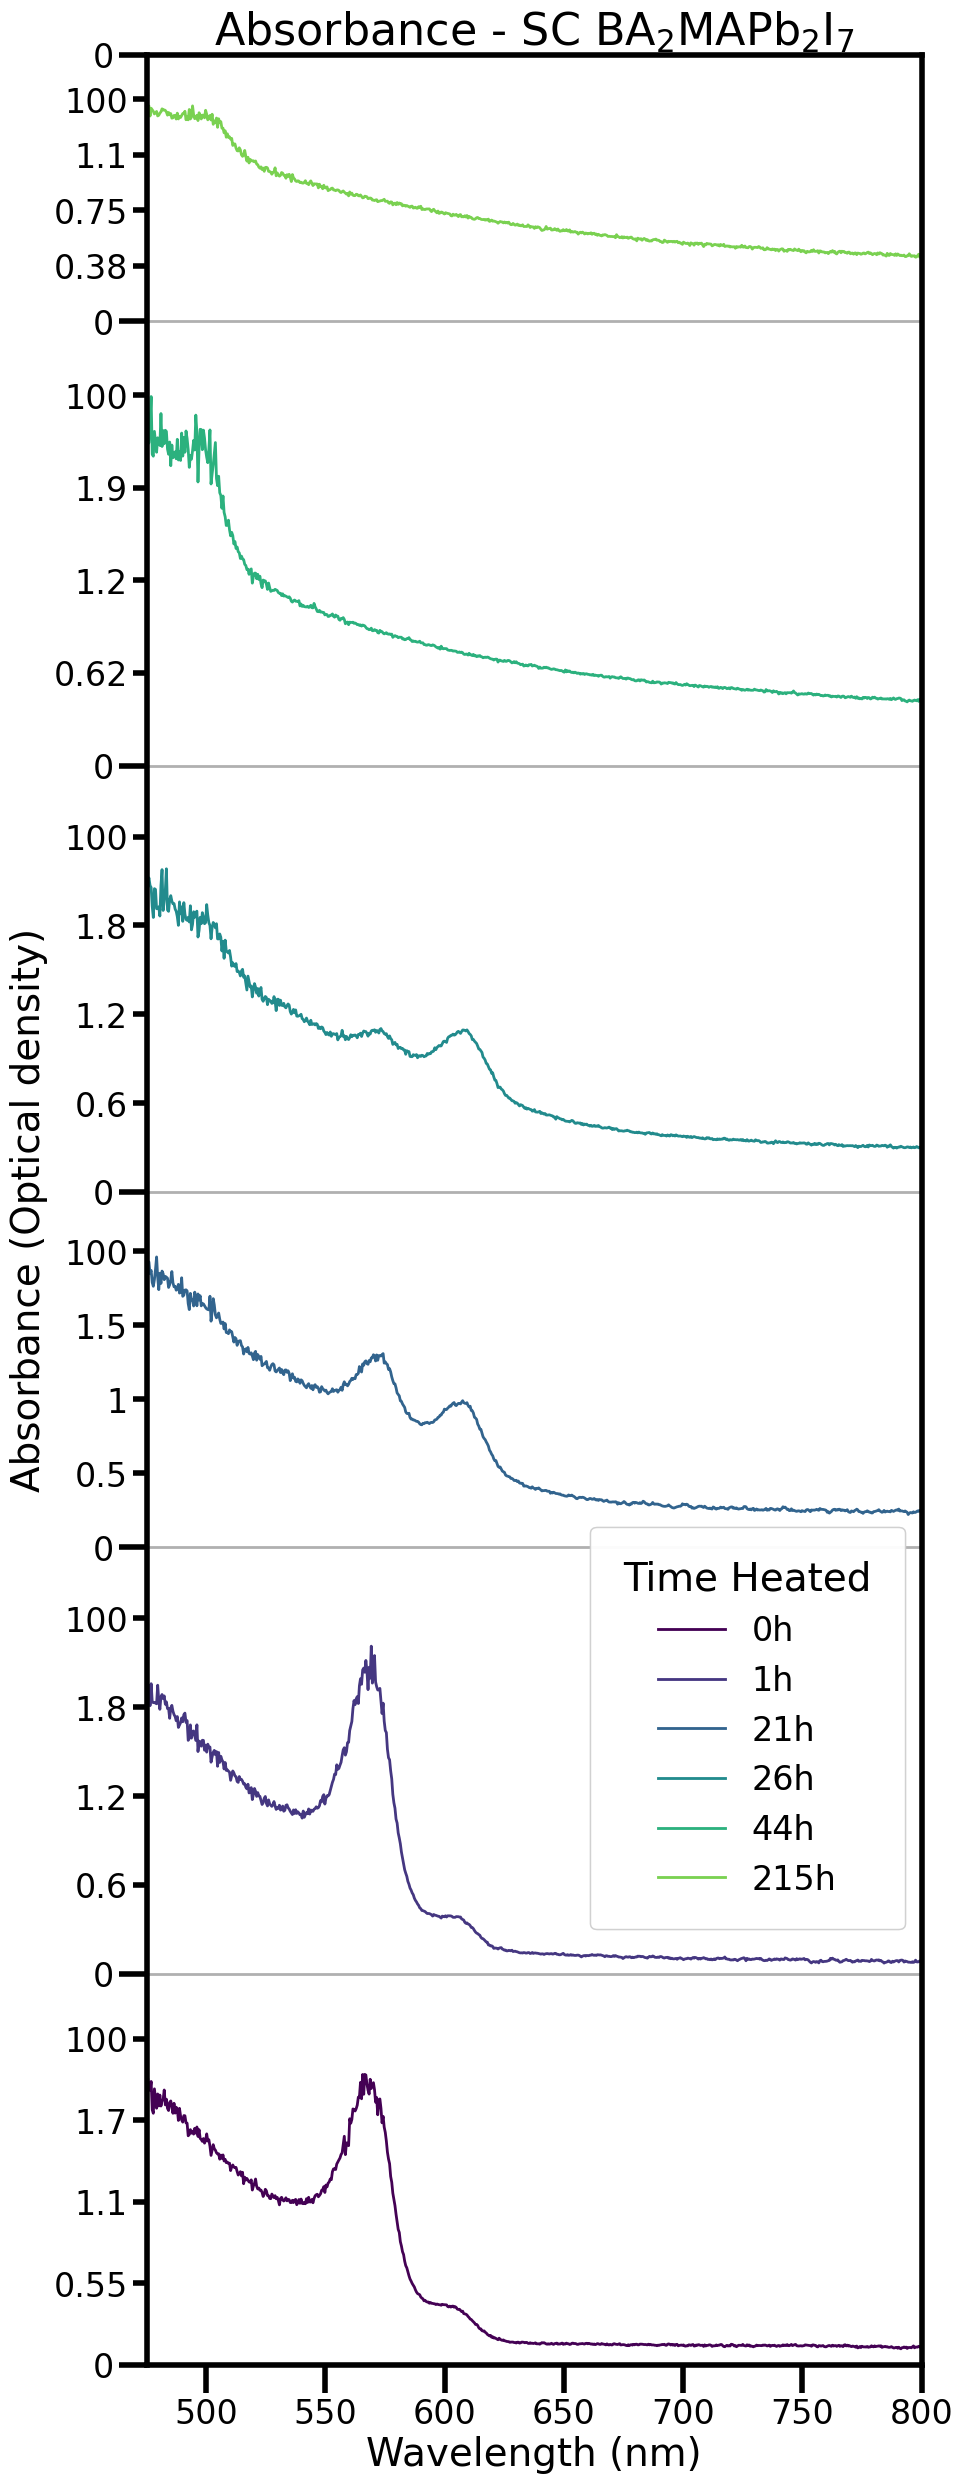

C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

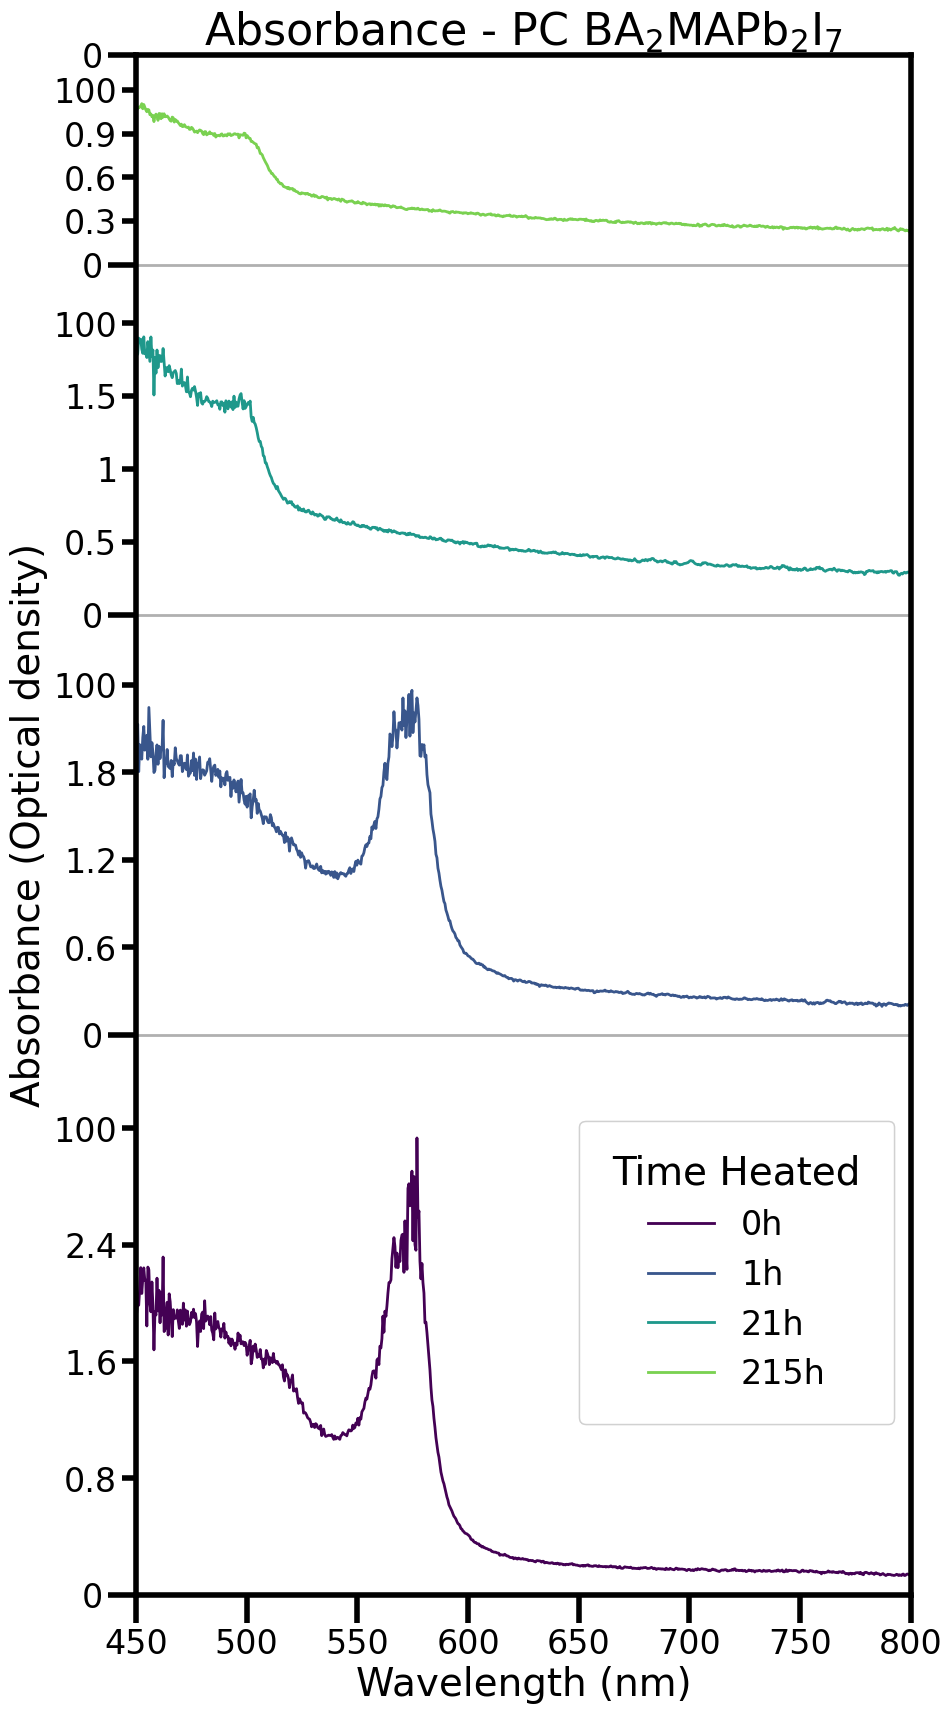

In [61]:
#for a graph of all absorptions for all times for a particular material.
line_width = 4
y_jump = 2.25

for i in [3, 4, 5]:
    if i == 3:
        y_jump = [2.00, 1.70, 0.62, 0.60]
        y_jump = [float(f"{v:.3g}") for v in y_jump]
    elif i == 4:
        y_jump = [2.2, 2.4, 2.0, 2.4, 2.5, 1.5]
        y_jump = [float(f"{v:.2g}") for v in y_jump]
    elif i == 5:
        y_jump = [3.2, 2.4, 2.0, 1.2]
        y_jump = [float(f"{v:.2g}") for v in y_jump]
    y_jump = [120/100 * i for i in y_jump]

    fig, ax = text_and_plot_stuff(figsize=(10,20), line_width=4, font_size=28, i=i)

    # set major and minor y-ticks using y_jump
    if i == 3 or i == 5:
        set_y_ticks(ax, y_jump)
    elif i == 4:
        set_y_ticks(ax, y_jump)

    #ax.yaxis.set_major_locator(MultipleLocator(100))
    #ax.xaxis.set_major_locator(MultipleLocator(100))
    #ax.xaxis.set_minor_locator(MultipleLocator(50))

    #scale bar
    # scale bar using y_jump
    #if i == 3:
        #add_scale_bars(ax, x_pos=775, y_jumps=y_jump, unit="O.D.", x_displace=-85, sig_fig=3)
    #elif i == 4:
        #dd_scale_bars(ax, x_pos=775, y_jumps=y_jump, unit="O.D.", x_displace=-70, sig_fig =2)
    #elif i == 5:
        #dd_scale_bars(ax, x_pos=775, y_jumps=y_jump, unit="O.D.", x_displace=-75, sig_fig =2)

    #if we want to disclude any graphs:
    times_indexs_not_to_plot = [3, 4, 5, 6, 7, 8, 9, 10, 11,12, 13]
    if i == 4:
        del times_indexs_not_to_plot[:2]

    valid_keys = [key for key_index, key in enumerate(data_dict) if key_index not in times_indexs_not_to_plot]
    #for key_index, key in enumerate(data_dict):
        #if key_index in times_indexs_not_to_plot:
            #continue
        #else:
            #valid_keys.append(key)
    #print(valid_keys)

    y_value_to_start = 0
    nth_plot = 0

    for key_index, key in enumerate(data_dict):
        if key_index in times_indexs_not_to_plot:
            continue
        else:
            nth_plot = nth_plot + 1
        energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background = seperated_data(data_dict[key])
        colour_index = (nth_plot-1) / (len(valid_keys)-1) * 0.8
        #print(colour_index)
        if i == 3:
            absorbancePlot(wavelength, incident, BA2PbI4_background, colour_index, key, y_value_to_start)
        if i == 4:
            absorbancePlot(wavelength, incident, SC_BA2MAPb2I7_background, colour_index, key, y_value_to_start)
        if i == 5:
            absorbancePlot(wavelength, incident, PC_BA2MAPb2I7_background, colour_index, key, y_value_to_start)

        y_value_to_start += y_jump[nth_plot - 1]
    if i == 3:
        plt.ylim(0, y_value_to_start)#-25)
    elif i == 4:
        plt.ylim(0, y_value_to_start)#-50)
    elif i == 5:
        plt.ylim(0, y_value_to_start)#-25)

    #Just copy and paste this code in for all the other stuff we need to plot
    #recall the name of the material use
    name = {3:r"BA$_{2}$PbI$_{4}$", 4:r"SC BA$_{2}$MAPb$_{2}$I$_{7}$", 5:r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"}[i]

    #finish the plots
    #fix, ax = plt.subplots(figsize = (1,2.5))
    #plt.ylim(0, 100)
    if i == 3 or i == 5:
        plt.xlim(450, 800)
    else:
        plt.xlim(475, 800)

    plt.title(f"Absorbance - {name}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorbance (Optical density)")

    #this si the stuff ot make the doubel legend box
    handles, labels, order = legend_setup()

    if i == 3:
        Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="best", title="Time Heated", borderpad=1, bbox_to_anchor=(0.55, 0.5))
    if i == 4:
        Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="best", title="Time Heated", borderpad=1, bbox_to_anchor=(1, 0.37))
    if i == 5:
        Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="lower right", title="Time Heated", borderpad=1, bbox_to_anchor=(1, 0.1))

    plt.gca().add_artist(Plot_legend)

    #savign the graphs
    name = {3:"BA2PbI4", 4:"SC BA2MAPb2I7", 5:"PC BA2MAPb2I7"}[i]
    vector_image = os.path.join(r"A:\Y4 Project code\Graphs", f"{name} Transmission.svg")
    png_image = os.path.join(r"A:\Y4 Project code\Graphs", f"{name} Transmission.png")
    plt.savefig(vector_image, bbox_inches='tight')
    plt.savefig(png_image, dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

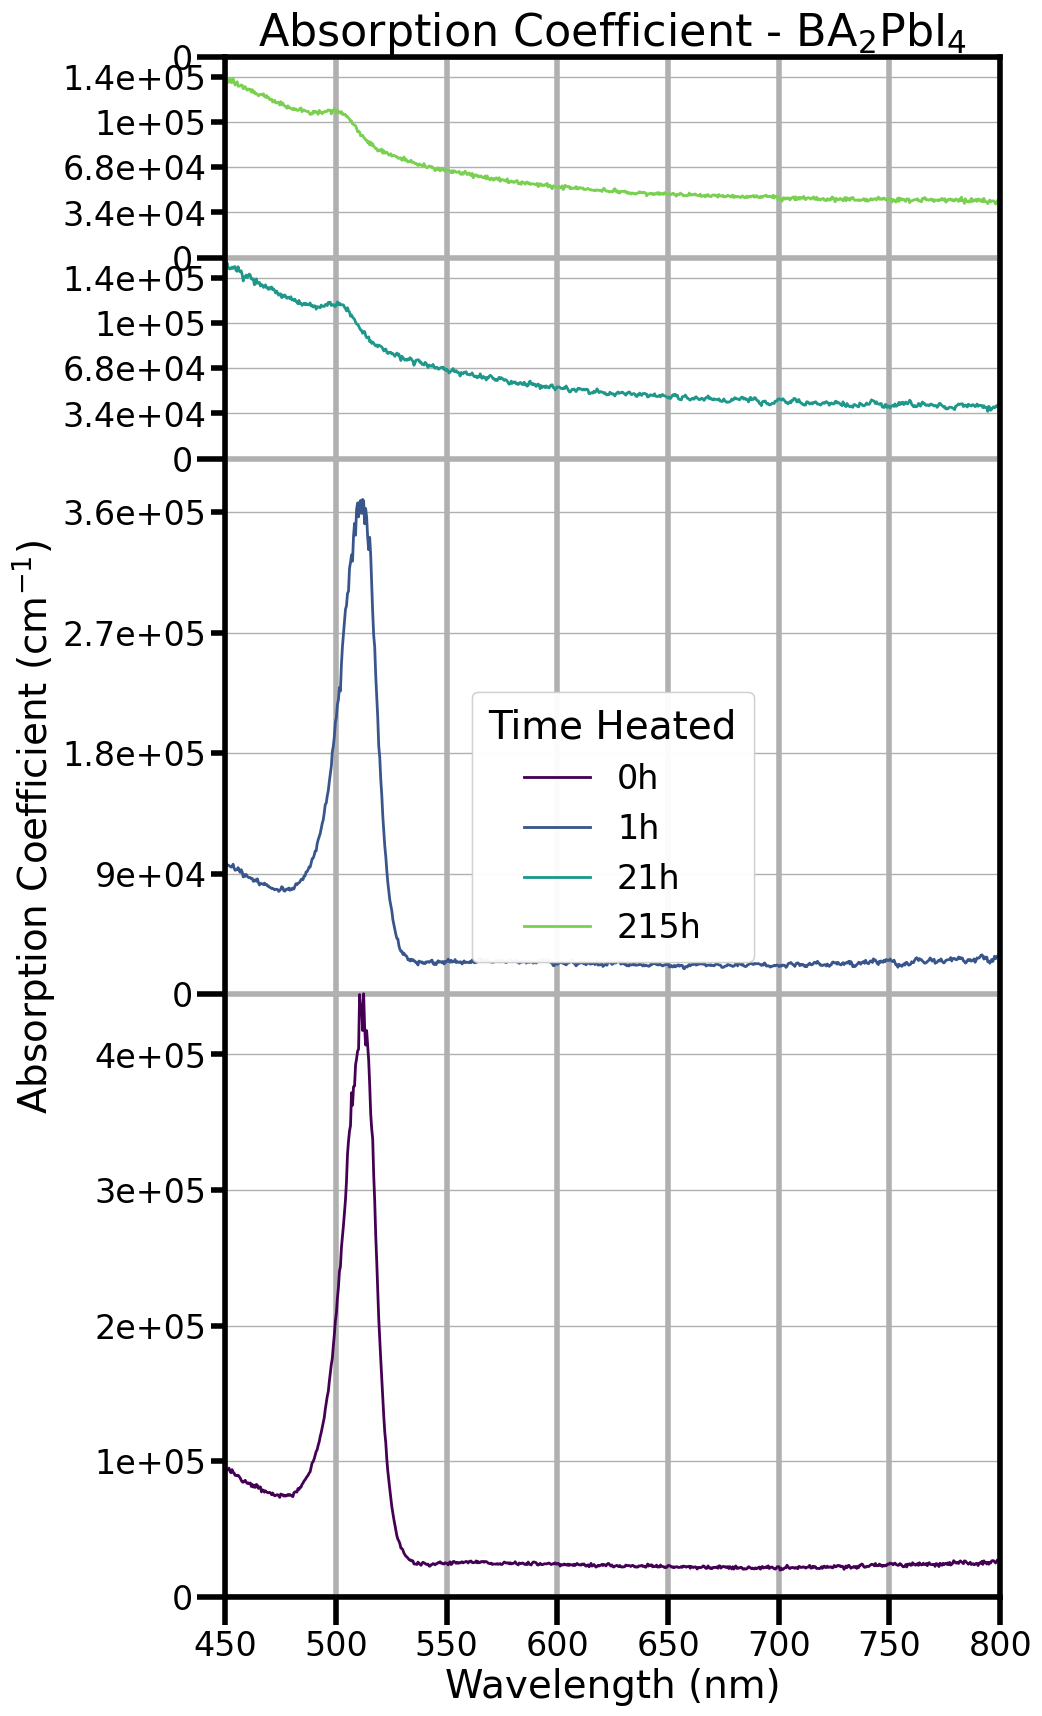

C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

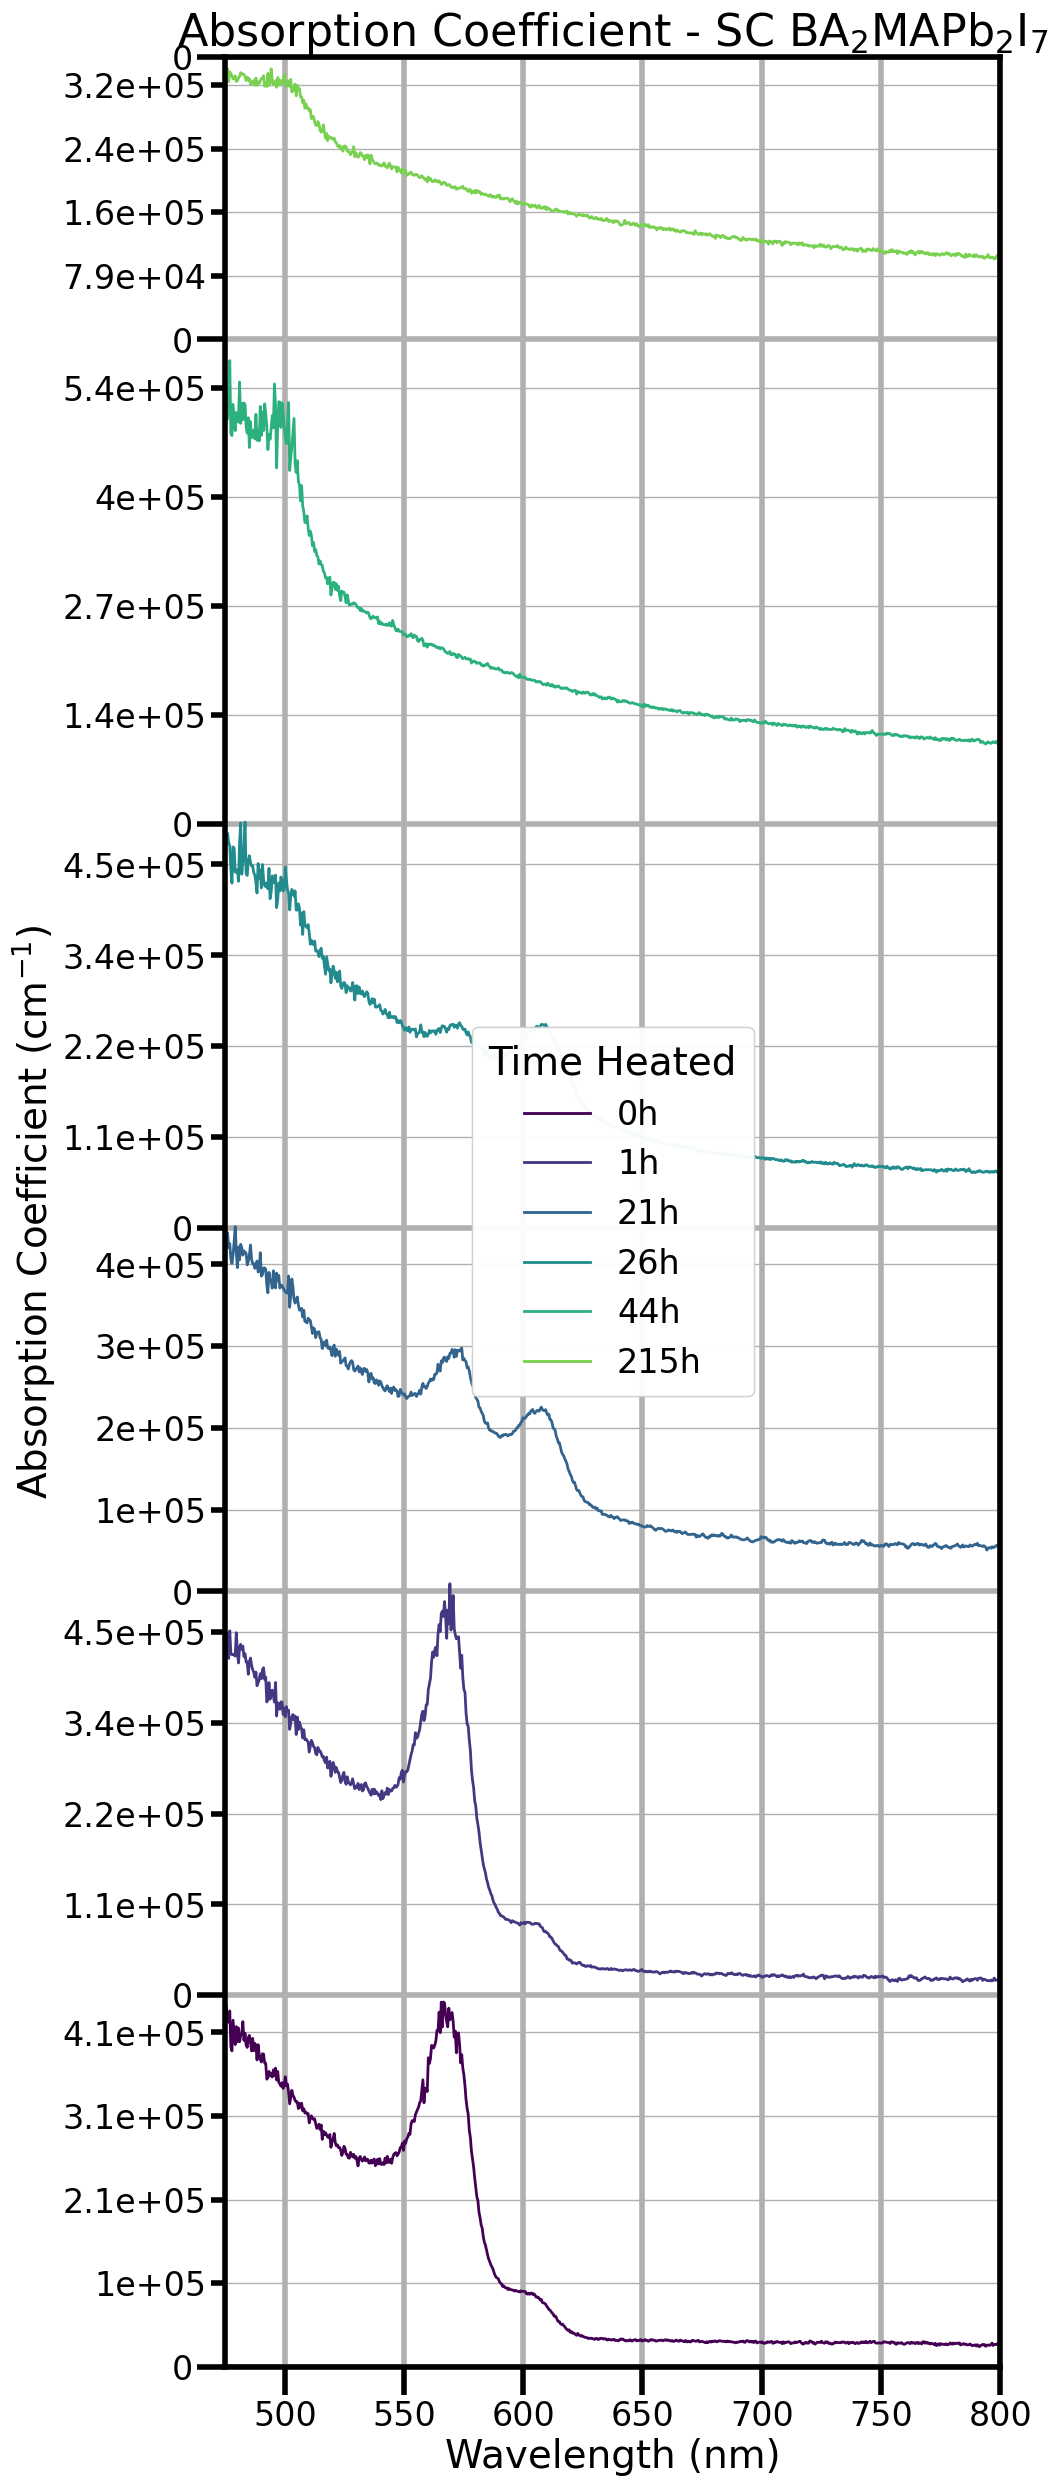

C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material/incident) * 100 #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_10532\2453196875.py:36: RuntimeWarning: invalid value

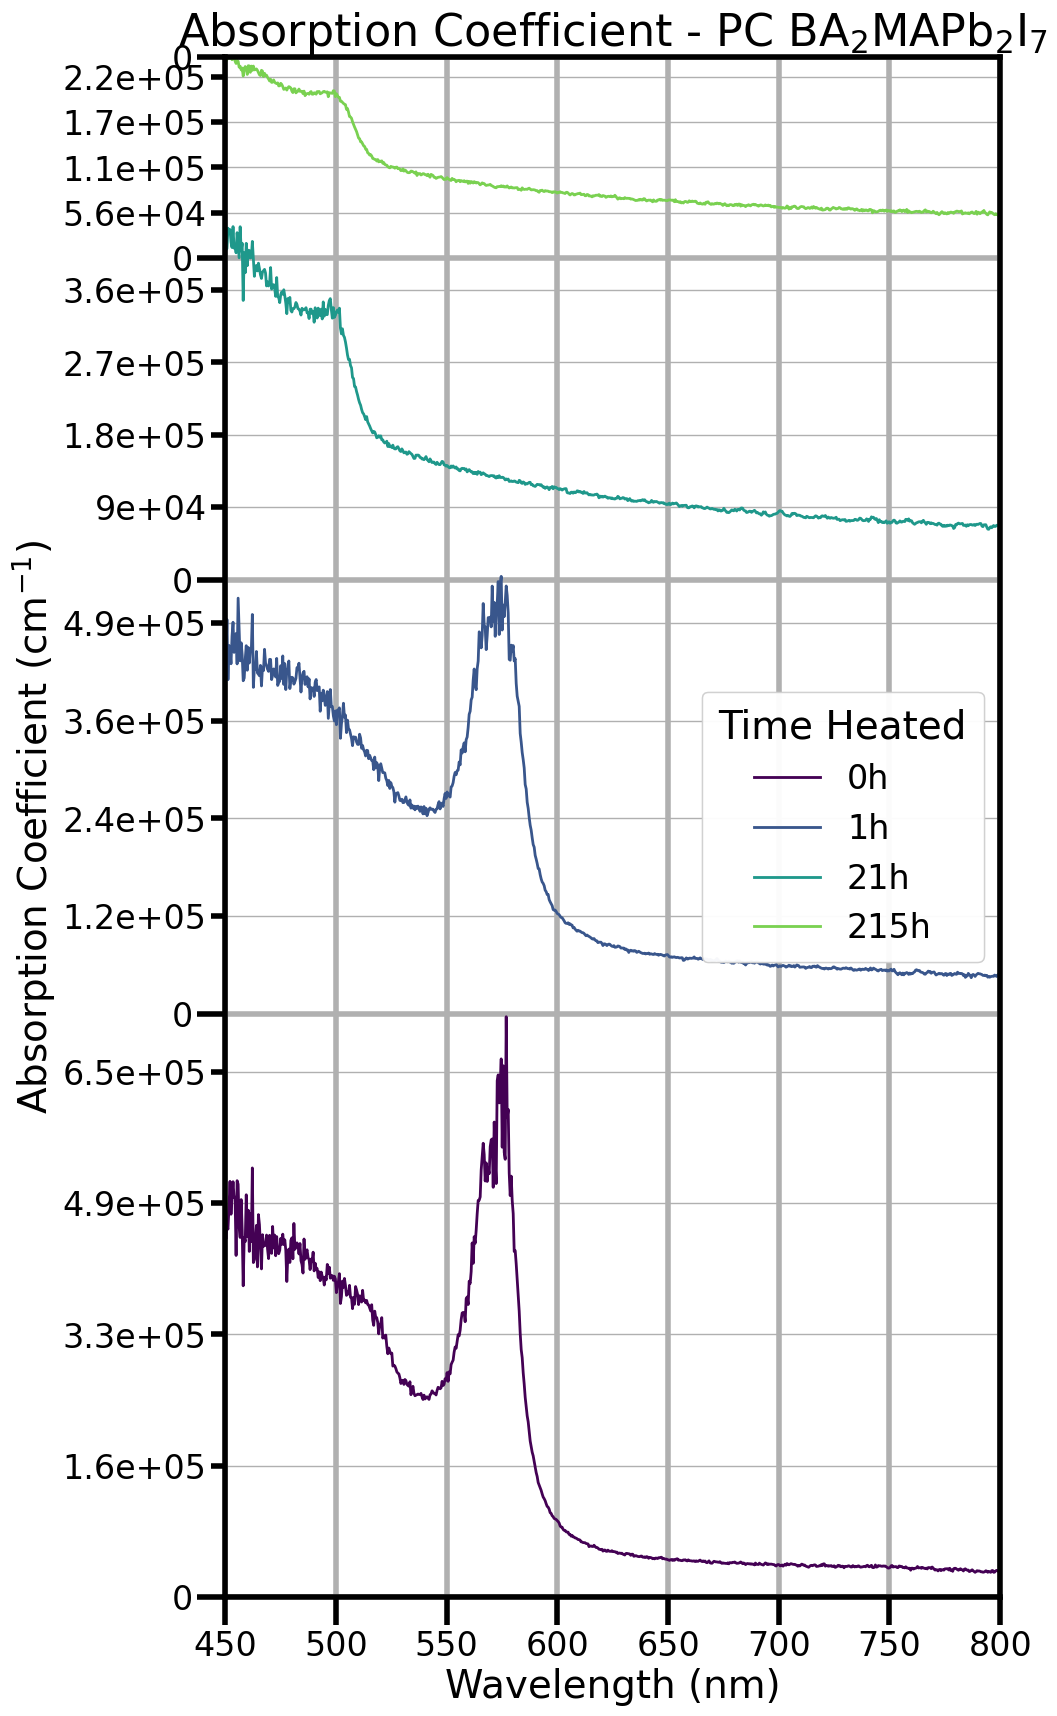

In [11]:
#for a graph of all absorbtion coefficients for all times for a particular material.
line_width = 4
y_jump = 2.25* 10 ** 5

for i in [3, 4, 5]:
    if i == 3:
        y_jump = [450000, 400000, 150000, 150000]
    elif i == 4:
        y_jump = [460000, 500000, 450000, 500000, 600000, 350000]
    elif i == 5:
        y_jump = [725000, 540000, 400000, 250000]
    y_jump = [120.100 * i for i in y_jump]

    fig, ax = text_and_plot_stuff(figsize=(10,20), line_width=4, font_size=28, i=i)

    # set major and minor y-ticks using y_jump
    if i == 3 or i == 5:
        set_y_ticks(ax, y_jump)
    elif i == 4:
        set_y_ticks(ax, y_jump)

    #ax.yaxis.set_major_locator(MultipleLocator(100))
    #ax.xaxis.set_major_locator(MultipleLocator(100))
    #ax.xaxis.set_minor_locator(MultipleLocator(50))

    #scale bar
    # scale bar using y_jump
    #if i == 3:
        #add_scale_bars(ax, x_pos=775, y_jumps=y_jump, unit="cm$^{-1}$", x_displace=-100, sig_fig =2)
    #elif i == 4:
        #add_scale_bars(ax, x_pos=775, y_jumps=y_jump, unit="cm$^{-1}$", x_displace=-100, sig_fig =2)
    #elif i == 5:
        #add_scale_bars(ax, x_pos=775, y_jumps=y_jump, unit="cm$^{-1}$", x_displace=-100, sig_fig =2)

    #if we want to disclude any graphs:
    times_indexs_not_to_plot = [3, 4, 5, 6, 7, 8, 9, 10, 11,12, 13]
    if i == 4:
        del times_indexs_not_to_plot[:2]

    valid_keys = [key for key_index, key in enumerate(data_dict) if key_index not in times_indexs_not_to_plot]
    #for key_index, key in enumerate(data_dict):
        #if key_index in times_indexs_not_to_plot:
            #continue
        #else:
            #valid_keys.append(key)
    #print(valid_keys)

    y_value_to_start = 0
    nth_plot = 0

    for key_index, key in enumerate(data_dict):
        if key_index in times_indexs_not_to_plot:
            continue
        else:
            nth_plot = nth_plot + 1
        energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background = seperated_data(data_dict[key])
        colour_index = (nth_plot-1) / (len(valid_keys)-1) * 0.8
        #print(colour_index)
        if i == 3:
            AbsCoPlot(wavelength, incident, BA2PbI4_background, colour_index, key, y_value_to_start)
        if i == 4:
            AbsCoPlot(wavelength, incident, SC_BA2MAPb2I7_background, colour_index, key, y_value_to_start)
        if i == 5:
            AbsCoPlot(wavelength, incident, PC_BA2MAPb2I7_background, colour_index, key, y_value_to_start)

        y_value_to_start += y_jump[nth_plot - 1]
    if i == 3:
        plt.ylim(0, y_value_to_start)#-25)
    elif i == 4:
        plt.ylim(0, y_value_to_start)#-50)
    elif i == 5:
        plt.ylim(0, y_value_to_start)#-25)

    #Just copy and paste this code in for all the other stuff we need to plot
    #recall the name of the material used
    name = {3:r"BA$_{2}$PbI$_{4}$", 4:r"SC BA$_{2}$MAPb$_{2}$I$_{7}$", 5:r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"}[i]

    #finish the plots
    #fix, ax = plt.subplots(figsize = (1,2.5))
    #plt.ylim(0, 100)
    if i == 3 or i == 5:
        plt.xlim(450, 800)
    else:
        plt.xlim(475, 800)

    plt.title(f"Absorption Coefficient - {name}")
    plt.xlabel(r"Wavelength (nm)")
    plt.ylabel("Absorption Coefficient (cm$^{-1}$)")

    #this si the stuff ot make the doubel legend box
    handles, labels, order = legend_setup()

    Plot_legend = plt.legend(np.array(handles)[order], np.array(labels)[order], loc="best", title="Time Heated", borderpad=0.5)
    plt.gca().add_artist(Plot_legend)

    #savign the graphs
    name = {3:"BA2PbI4", 4:"SC BA2MAPb2I7", 5:"PC BA2MAPb2I7"}[i]
    vector_image = os.path.join(r"A:\Y4 Project code\Graphs", f"{name} AbsCO.svg")
    png_image = os.path.join(r"A:\Y4 Project code\Graphs", f"{name} AbsCO.png")
    plt.savefig(vector_image, bbox_inches='tight')
    plt.savefig(png_image, dpi=300, bbox_inches='tight')
    plt.show()